# Batch Normalization

Batch Normalization을 사용해보자!

***Batch Normalization도 Dropout처럼 학습에만 적용되도록 `model.train()`, `model.eval()`을 사용해주어야 함***

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(1)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(1)

In [2]:
batch_size = 32
learning_rate = 0.001
n_epochs = 10

In [3]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

mnist_path = "../datasets/MNIST_data/"

mnist_train = dsets.MNIST(root=mnist_path, train=True, transform=transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root=mnist_path, train=False, transform=transforms.ToTensor(),
                         download=True)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [5]:
from torch import nn

class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 32, bias=True)
        self.linear2 = nn.Linear(32, 32, bias=True)
        self.linear3 = nn.Linear(32, 10, bias=True)
        self.relu = nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.bn2 = torch.nn.BatchNorm1d(32)
        
        nn.init.kaiming_normal_(self.linear1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.linear2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.linear3.weight, nonlinearity='relu')
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.linear3(x)        
        
        return x
    
    
model = MNISTClassifier().to(device)

In [6]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

In [7]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(n_epochs):
    # training에는 dropout 켜기
    model.train()
        
    for X, Y in train_loader:
        X = X.view(-1, 784).to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X)
        loss = criterion(hypothesis, Y)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()
        
        # Training Accuracy & Loss
        train_acc = 0
        train_loss = 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 784).to(device)
            Y = Y.to(device)
            
            predictions = model(X)
            correct_predictions = (torch.argmax(predictions, dim=1) == Y)
            train_acc += correct_predictions.float().mean()
            train_loss += criterion(predictions, Y)
        
        train_acc = train_acc / len(train_loader)
        train_loss = train_loss / len(train_loader)
        
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        
        # Validation Accuracy & Loss
        val_acc = 0
        val_loss = 0
        for i, (X, Y) in enumerate(val_loader):
            X = X.view(-1, 784).to(device)
            Y = Y.to(device)
            
            predictions = model(X)
            correct_predictions = (torch.argmax(predictions, dim=1) == Y)
            val_acc += correct_predictions.float().mean()
            val_loss += criterion(predictions, Y)
        
        val_acc = val_acc / len(val_loader)
        val_loss = val_loss / len(val_loader)
        
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        
        print("[Epoch {:04d}]".format(epoch+1))
        print("Train: Accuracy {:.3f}, Loss {:.3f}".format(train_acc, train_loss))
        print("Valid: Accuracy {:.3f}, Loss {:.3f}".format(val_acc, val_loss))

print("Learning Finished")        

[Epoch 0001]
Train: Accuracy 0.954, Loss 0.159
Valid: Accuracy 0.949, Loss 0.172
[Epoch 0002]
Train: Accuracy 0.966, Loss 0.114
Valid: Accuracy 0.961, Loss 0.134
[Epoch 0003]
Train: Accuracy 0.972, Loss 0.092
Valid: Accuracy 0.966, Loss 0.114
[Epoch 0004]
Train: Accuracy 0.976, Loss 0.079
Valid: Accuracy 0.968, Loss 0.103
[Epoch 0005]
Train: Accuracy 0.979, Loss 0.070
Valid: Accuracy 0.968, Loss 0.103
[Epoch 0006]
Train: Accuracy 0.981, Loss 0.062
Valid: Accuracy 0.970, Loss 0.098
[Epoch 0007]
Train: Accuracy 0.983, Loss 0.057
Valid: Accuracy 0.971, Loss 0.096
[Epoch 0008]
Train: Accuracy 0.984, Loss 0.053
Valid: Accuracy 0.970, Loss 0.097
[Epoch 0009]
Train: Accuracy 0.984, Loss 0.050
Valid: Accuracy 0.971, Loss 0.092
[Epoch 0010]
Train: Accuracy 0.985, Loss 0.048
Valid: Accuracy 0.969, Loss 0.099
Learning Finished


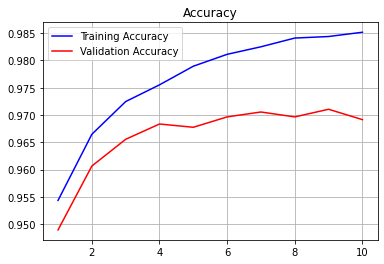

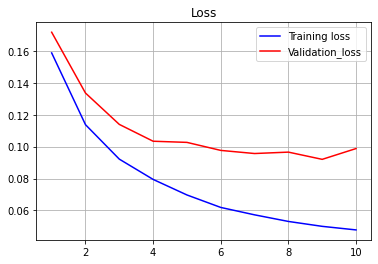

In [8]:
import matplotlib.pyplot as plt

epochs = range(1, n_epochs + 1)

plt.plot(epochs, train_accs, 'b', label='Training Accuracy')
plt.plot(epochs, val_accs, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid('on')

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation_loss')
plt.title('Loss')
plt.legend()
plt.grid('on')

plt.show()